In [1]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.misc
import os
import csv
import itertools
import tensorflow.contrib.slim as slim
%matplotlib inline

from helper import *

C:\Users\samsung\ANACONDA\envs\tf_1_py_3.7\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\samsung\ANACONDA\envs\tf_1_py_3.7\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\samsung\ANACONDA\envs\tf_1_py_3.7\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\samsung\ANACONDA\envs\tf_1_py_3.7\lib\site-

In [2]:
from gridworld import gameEnv

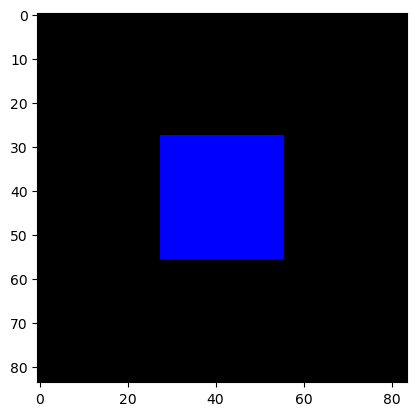

In [3]:
#full MDP
env = gameEnv(partial=False,size=9)
#partial MDP
env = gameEnv(partial=True,size=9)

Implementing network

In [4]:
class Qnetwork():
    def __init__(self,h_size,rnn_cell,myScope):
        #The network recieves a frame from the game, flattened into an array.
        #It then resizes it and processes it through four convolutional layers.
        self.scalarInput =  tf.placeholder(shape=[None,21168],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3])
        self.conv1 = slim.convolution2d( \
            inputs=self.imageIn,num_outputs=32,\
            kernel_size=[8,8],stride=[4,4],padding='VALID', \
            biases_initializer=None,scope=myScope+'_conv1')
        self.conv2 = slim.convolution2d( \
            inputs=self.conv1,num_outputs=64,\
            kernel_size=[4,4],stride=[2,2],padding='VALID', \
            biases_initializer=None,scope=myScope+'_conv2')
        self.conv3 = slim.convolution2d( \
            inputs=self.conv2,num_outputs=64,\
            kernel_size=[3,3],stride=[1,1],padding='VALID', \
            biases_initializer=None,scope=myScope+'_conv3')
        self.conv4 = slim.convolution2d( \
            inputs=self.conv3,num_outputs=h_size,\
            kernel_size=[7,7],stride=[1,1],padding='VALID', \
            biases_initializer=None,scope=myScope+'_conv4')
        
        self.trainLength = tf.placeholder(dtype=tf.int32)
        #We take the output from the final convolutional layer and send it to a recurrent layer.
        #The input must be reshaped into [batch x trace x units] for rnn processing, 
        #and then returned to [batch x units] when sent through the upper levles.
        self.batch_size = tf.placeholder(dtype=tf.int32,shape=[])
        self.convFlat = tf.reshape(slim.flatten(self.conv4),[self.batch_size,self.trainLength,h_size])
        self.state_in = rnn_cell.zero_state(self.batch_size, tf.float32)
        self.rnn,self.rnn_state = tf.nn.dynamic_rnn(\
                inputs=self.convFlat,cell=rnn_cell,dtype=tf.float32,initial_state=self.state_in,scope=myScope+'_rnn')
        self.rnn = tf.reshape(self.rnn,shape=[-1,h_size])
        #The output from the recurrent player is then split into separate Value and Advantage streams
        self.streamA,self.streamV = tf.split(self.rnn,2,1)
        self.AW = tf.Variable(tf.random_normal([h_size//2,4]))
        self.VW = tf.Variable(tf.random_normal([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        self.salience = tf.gradients(self.Advantage,self.imageIn)
        #Then combine them together to get our final Q-values.
        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,axis=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        
        #Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,4,dtype=tf.float32)
        
        self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
        
        self.td_error = tf.square(self.targetQ - self.Q)
        
        #In order to only propogate accurate gradients through the network, we will mask the first
        #half of the losses for each trace as per Lample & Chatlot 2016
        self.maskA = tf.zeros([self.batch_size,self.trainLength//2])
        self.maskB = tf.ones([self.batch_size,self.trainLength//2])
        self.mask = tf.concat([self.maskA,self.maskB],1)
        self.mask = tf.reshape(self.mask,[-1])
        self.loss = tf.reduce_mean(self.td_error * self.mask)
        
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

experience replay

In [5]:
class experience_buffer():
    def __init__(self, buffer_size = 1000):
        self.buffer = []
        self.buffer_size = buffer_size
    
    def add(self,experience):
        if len(self.buffer) + 1 >= self.buffer_size:
            self.buffer[0:(1+len(self.buffer))-self.buffer_size] = []
        self.buffer.append(experience)
            
    def sample(self,batch_size,trace_length):
        sampled_episodes = random.sample(self.buffer,batch_size)
        sampledTraces = []
        for episode in sampled_episodes:
            point = np.random.randint(0,len(episode)+1-trace_length)
            sampledTraces.append(episode[point:point+trace_length])
        sampledTraces = np.array(sampledTraces)
        return np.reshape(sampledTraces,[batch_size*trace_length,5])

training the network

In [6]:
#Setting the training parameters
batch_size = 4 #How many experience traces to use for each training step.
trace_length = 8 #How long each experience trace will be when training
update_freq = 5 #How often to perform a training step.
y = .99 #Discount factor on the target Q-values
startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
anneling_steps = 10000 #How many steps of training to reduce startE to endE.
num_episodes = 3000 #How many episodes of game environment to train network with.
pre_train_steps = 10000 #How many steps of random actions before training begins.
load_model = False #Whether to load a saved model.
path = "./drqn" #The path to save our model to.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
max_epLength = 50 #The max allowed length of our episode.
time_per_step = 1 #Length of each step used in gif creation
summaryLength = 100 #Number of epidoes to periodically save for analysis
tau = 0.001

In [ ]:
tf.reset_default_graph()
#We define the cells for the primary and target q-networks
cell = tf.contrib.rnn.BasicLSTMCell(num_units=h_size,state_is_tuple=True)
cellT = tf.contrib.rnn.BasicLSTMCell(num_units=h_size,state_is_tuple=True)
mainQN = Qnetwork(h_size,cell,'main')
targetQN = Qnetwork(h_size,cellT,'target')

init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=5)

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease. 
e = startE
stepDrop = (startE - endE)/anneling_steps

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

##Write the first line of the master log-file for the Control Center
with open('./Center/log.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(['Episode','Length','Reward','IMG','LOG','SAL'])    
  

with tf.Session() as sess:
    if load_model == True:
        print ('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    sess.run(init)
   
    updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP)
        d = False
        rAll = 0
        j = 0
        state = (np.zeros([1,h_size]),np.zeros([1,h_size])) #Reset the recurrent layer's hidden state
        #The Q-Network
        while j < max_epLength: 
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                state1 = sess.run(mainQN.rnn_state,\
                    feed_dict={mainQN.scalarInput:[s/255.0],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                a = np.random.randint(0,4)
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                    feed_dict={mainQN.scalarInput:[s/255.0],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                a = a[0]
            s1P,r,d = env.step(a)
            s1 = processState(s1P)
            total_steps += 1
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5]))
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop

                if total_steps % (update_freq) == 0:
                    updateTarget(targetOps,sess)
                    #Reset the recurrent layer's hidden state
                    state_train = (np.zeros([batch_size,h_size]),np.zeros([batch_size,h_size])) 
                    
                    trainBatch = myBuffer.sample(batch_size,trace_length) #Get a random batch of experiences.
                    #Below we perform the Double-DQN update to the target Q-values
                    Q1 = sess.run(mainQN.predict,feed_dict={\
                        mainQN.scalarInput:np.vstack(trainBatch[:,3]/255.0),\
                        mainQN.trainLength:trace_length,mainQN.state_in:state_train,mainQN.batch_size:batch_size})
                    Q2 = sess.run(targetQN.Qout,feed_dict={\
                        targetQN.scalarInput:np.vstack(trainBatch[:,3]/255.0),\
                        targetQN.trainLength:trace_length,targetQN.state_in:state_train,targetQN.batch_size:batch_size})
                    end_multiplier = -(trainBatch[:,4] - 1)
                    doubleQ = Q2[range(batch_size*trace_length),Q1]
                    targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                    #Update the network with our target values.
                    sess.run(mainQN.updateModel, \
                        feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]/255.0),mainQN.targetQ:targetQ,\
                        mainQN.actions:trainBatch[:,1],mainQN.trainLength:trace_length,\
                        mainQN.state_in:state_train,mainQN.batch_size:batch_size})
            rAll += r
            s = s1
            sP = s1P
            state = state1
            if d == True:

                break

        #Add the episode to the experience buffer
        bufferArray = np.array(episodeBuffer)
        episodeBuffer = list(zip(bufferArray))
        myBuffer.add(episodeBuffer)
        jList.append(j)
        rList.append(rAll)

        #Periodically save the model. 
        if i % 1000 == 0 and i != 0:
            saver.save(sess,path+'/model-'+str(i)+'.cptk')
            print ("Saved Model")
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            print (total_steps,np.mean(rList[-summaryLength:]), e)
            saveToCenter(i,rList,jList,np.reshape(np.array(episodeBuffer),[len(episodeBuffer),5]),\
                summaryLength,h_size,sess,mainQN,time_per_step)
    saver.save(sess,path+'/model-'+str(i)+'.cptk')


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





Target Set Success


C:\Users\samsung\ANACONDA\envs\tf_1_py_3.7\lib\site-packages\ipykernel_launcher.py:69: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


5000 0.73 1
MoviePy - Building file ./Center/frames/sal99.gif with imageio.


MoviePy - Building file ./Center/frames/image99.gif with imageio.


10000 0.6 1
MoviePy - Building file ./Center/frames/sal199.gif with imageio.


MoviePy - Building file ./Center/frames/image199.gif with imageio.


Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

MoviePy - Building file ./Center/frames/image299.gif with imageio.


Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

MoviePy - Building file ./Center/frames/image399.gif with imageio.


Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

MoviePy - Building file ./Center/frames/image499.gif with imageio.


Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

MoviePy - Building file ./Center/frames/image599.gif with imageio.


Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

MoviePy - Building file ./Center/frames/image699.gif with imageio.


Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

MoviePy - Building file ./Center/frames/image799.gif with imageio.


Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

MoviePy - Building file ./Center/frames/image899.gif with imageio.


Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

MoviePy - Building file ./Center/frames/image999.gif with imageio.


Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Saved Model
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success


MoviePy - Building file ./Center/frames/image1099.gif with imageio.


Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

MoviePy - Building file ./Center/frames/image1199.gif with imageio.


Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

MoviePy - Building file ./Center/frames/image1299.gif with imageio.


Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

MoviePy - Building file ./Center/frames/image1399.gif with imageio.


Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

MoviePy - Building file ./Center/frames/image1499.gif with imageio.


Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

MoviePy - Building file ./Center/frames/image1599.gif with imageio.


Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

MoviePy - Building file ./Center/frames/image1699.gif with imageio.


Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

MoviePy - Building file ./Center/frames/image1799.gif with imageio.


Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

MoviePy - Building file ./Center/frames/image1899.gif with imageio.


Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

MoviePy - Building file ./Center/frames/image1999.gif with imageio.


Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Saved Model
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success


MoviePy - Building file ./Center/frames/image2099.gif with imageio.


Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

MoviePy - Building file ./Center/frames/image2199.gif with imageio.


Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

MoviePy - Building file ./Center/frames/image2299.gif with imageio.


Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

MoviePy - Building file ./Center/frames/image2399.gif with imageio.


Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

MoviePy - Building file ./Center/frames/image2499.gif with imageio.


Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

MoviePy - Building file ./Center/frames/image2599.gif with imageio.


Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

MoviePy - Building file ./Center/frames/image2699.gif with imageio.


Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

MoviePy - Building file ./Center/frames/image2799.gif with imageio.


Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

MoviePy - Building file ./Center/frames/image2899.gif with imageio.


Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set S

MoviePy - Building file ./Center/frames/image2999.gif with imageio.


Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Saved Model
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success
Target Set Success


# testing network - 실행 시간 길어서 끊음

In [6]:
e = 0.01 #The chance of chosing a random action
num_episodes = 10000 #How many episodes of game environment to train network with.
load_model = True #Whether to load a saved model.
path = "./drqn" #The path to save/load our model to/from.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
h_size = 512 #The size of the final convolutional layer before splitting it into Advantage and Value streams.
max_epLength = 50 #The max allowed length of our episode.
time_per_step = 1 #Length of each step used in gif creation
summaryLength = 100 #Number of epidoes to periodically save for analysis

In [7]:
tf.reset_default_graph()
cell = tf.contrib.rnn.BasicLSTMCell(num_units=h_size,state_is_tuple=True)
cellT = tf.contrib.rnn.BasicLSTMCell(num_units=h_size,state_is_tuple=True)
mainQN = Qnetwork(h_size,cell,'main')
targetQN = Qnetwork(h_size,cellT,'target')

init = tf.global_variables_initializer()

saver = tf.train.Saver(max_to_keep=2)

#create lists to contain total rewards and steps per episode
jList = []
rList = []
total_steps = 0

#Make a path for our model to be saved in.
if not os.path.exists(path):
    os.makedirs(path)

##Write the first line of the master log-file for the Control Center
with open('./Center/log.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(['Episode','Length','Reward','IMG','LOG','SAL'])    
    
    #wr = csv.writer(open('./Center/log.csv', 'a'), quoting=csv.QUOTE_ALL)
with tf.Session() as sess:
    if load_model == True:
        print ('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    else:
        sess.run(init)

        
    for i in range(num_episodes):
        episodeBuffer = []
        #Reset environment and get first new observation
        sP = env.reset()
        s = processState(sP)
        d = False
        rAll = 0
        j = 0
        state = (np.zeros([1,h_size]),np.zeros([1,h_size]))
        #The Q-Network
        while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e:
                state1 = sess.run(mainQN.rnn_state,\
                    feed_dict={mainQN.scalarInput:[s/255.0],mainQN.trainLength:1,mainQN.state_in:state,mainQN.batch_size:1})
                a = np.random.randint(0,4)
            else:
                a, state1 = sess.run([mainQN.predict,mainQN.rnn_state],\
                    feed_dict={mainQN.scalarInput:[s/255.0],mainQN.trainLength:1,\
                    mainQN.state_in:state,mainQN.batch_size:1})
                a = a[0]
            s1P,r,d = env.step(a)
            s1 = processState(s1P)
            total_steps += 1
            episodeBuffer.append(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #Save the experience to our episode buffer.
            rAll += r
            s = s1
            sP = s1P
            state = state1
            if d == True:

                break

        bufferArray = np.array(episodeBuffer)
        jList.append(j)
        rList.append(rAll)

        #Periodically save the model. 
        if len(rList) % summaryLength == 0 and len(rList) != 0:
            print (total_steps,np.mean(rList[-summaryLength:]), e)
            saveToCenter(i,rList,jList,np.reshape(np.array(episodeBuffer),[len(episodeBuffer),5]),\
                summaryLength,h_size,sess,mainQN,time_per_step)
print ("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")


Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





Loading Model...
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./drqn\model-3000.cptk


C:\Users\samsung\ANACONDA\envs\tf_1_py_3.7\lib\site-packages\ipykernel_launcher.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


5000 6.36 0.01
MoviePy - Building file ./Center/frames/sal99.gif with imageio.


MoviePy - Building file ./Center/frames/image99.gif with imageio.


10000 6.28 0.01
MoviePy - Building file ./Center/frames/sal199.gif with imageio.


MoviePy - Building file ./Center/frames/image199.gif with imageio.


15000 6.49 0.01
MoviePy - Building file ./Center/frames/sal299.gif with imageio.


MoviePy - Building file ./Center/frames/image299.gif with imageio.


20000 6.49 0.01
MoviePy - Building file ./Center/frames/sal399.gif with imageio.


MoviePy - Building file ./Center/frames/image399.gif with imageio.


25000 6.33 0.01
MoviePy - Building file ./Center/frames/sal499.gif with imageio.


MoviePy - Building file ./Center/frames/image499.gif with imageio.


30000 5.88 0.01
MoviePy - Building file ./Center/frames/sal599.gif with imageio.


MoviePy - Building file ./Center/frames/image599.gif with imageio.


35000 5.77 0.01
MoviePy - Building file ./Center/frames/sal699.gif with imageio.


MoviePy - Building file ./Center/frames/image699.gif with imageio.


40000 6.03 0.01
MoviePy - Building file ./Center/frames/sal799.gif with imageio.


MoviePy - Building file ./Center/frames/image799.gif with imageio.


45000 6.13 0.01
MoviePy - Building file ./Center/frames/sal899.gif with imageio.


MoviePy - Building file ./Center/frames/image899.gif with imageio.


50000 6.05 0.01
MoviePy - Building file ./Center/frames/sal999.gif with imageio.


MoviePy - Building file ./Center/frames/image999.gif with imageio.


55000 5.62 0.01
MoviePy - Building file ./Center/frames/sal1099.gif with imageio.


MoviePy - Building file ./Center/frames/image1099.gif with imageio.


60000 6.1 0.01
MoviePy - Building file ./Center/frames/sal1199.gif with imageio.


MoviePy - Building file ./Center/frames/image1199.gif with imageio.


65000 5.81 0.01
MoviePy - Building file ./Center/frames/sal1299.gif with imageio.


MoviePy - Building file ./Center/frames/image1299.gif with imageio.


70000 6.02 0.01
MoviePy - Building file ./Center/frames/sal1399.gif with imageio.


MoviePy - Building file ./Center/frames/image1399.gif with imageio.


75000 6.14 0.01
MoviePy - Building file ./Center/frames/sal1499.gif with imageio.


MoviePy - Building file ./Center/frames/image1499.gif with imageio.


80000 6.19 0.01
MoviePy - Building file ./Center/frames/sal1599.gif with imageio.


MoviePy - Building file ./Center/frames/image1599.gif with imageio.


85000 5.89 0.01
MoviePy - Building file ./Center/frames/sal1699.gif with imageio.


MoviePy - Building file ./Center/frames/image1699.gif with imageio.


90000 6.18 0.01
MoviePy - Building file ./Center/frames/sal1799.gif with imageio.


MoviePy - Building file ./Center/frames/image1799.gif with imageio.


95000 6.34 0.01
MoviePy - Building file ./Center/frames/sal1899.gif with imageio.


MoviePy - Building file ./Center/frames/image1899.gif with imageio.


KeyboardInterrupt: 